# Ultimate Inc. Take-Home Challenge

In [1]:
# Importing necessary packages
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
sns.set_context("poster")
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Part 1 - Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
# Uploading Logins json and inspecting the data
df_logins = pd.read_json('/Users/dwreiter/Desktop/Work/Springboard/Data Stuff/ultimate_challenge/logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# No missing values
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [4]:
# Making sure the login times are in order
df_logins = df_logins.sort_values(by='login_time')
df_logins = df_logins.reset_index(drop=True)
df_logins.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [5]:
# Seeing where the login times end
df_logins.tail()

,login_time
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23
93141,1970-04-13 18:57:38


In [6]:
# Setting up a Date Range for the logins
date_range = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
date_range = pd.Series(np.zeros(len(date_range)), index=date_range)
date_range.head()

1970-01-01 20:00:00    0.0
1970-01-01 20:15:00    0.0
1970-01-01 20:30:00    0.0
1970-01-01 20:45:00    0.0
1970-01-01 21:00:00    0.0
Freq: 15T, dtype: float64

In [7]:
# Starting time period at zero
p = 0 

# For Loop to use the Date Range on the data
for i in range(len(df_logins)):
    s = date_range.index[p] # Start time
    e = date_range.index[p+1] # End time
    t = df_logins['login_time'][i]
    if s < t < e:
        date_range[p] = date_range[p] + 1
    else:
        while (e < t): # Increment to the next time 
            p = p + 1 
            s = date_range.index[p] # Change start time
            e = date_range.index[p+1] # Change end time
        date_range[p] = date_range[p] + 1

In [8]:
# Viewing the top and bottom of the Date Range
print(date_range.head())
print(date_range.tail())

1970-01-01 20:00:00    2.0
1970-01-01 20:15:00    6.0
1970-01-01 20:30:00    9.0
1970-01-01 20:45:00    7.0
1970-01-01 21:00:00    1.0
Freq: 15T, dtype: float64
1970-04-13 18:00:00    5.0
1970-04-13 18:15:00    2.0
1970-04-13 18:30:00    7.0
1970-04-13 18:45:00    6.0
1970-04-13 19:00:00    0.0
Freq: 15T, dtype: float64


In [9]:
# The most logins for a 15-minute time frame is 73.
date_range.max()

73.0

Text(0.5,1,'Logins By Month')

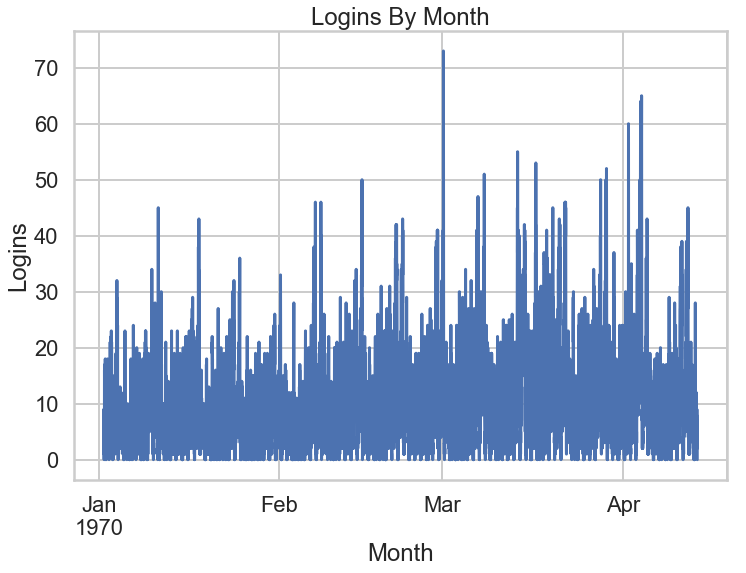

In [10]:
# Plotting Logins By Month
ax = date_range.plot()
ax.set_xlabel('Month')
ax.set_ylabel('Logins')
ax.set_title('Logins By Month')

** Looking at the above plot, there seems to be big increase essentially every week in each month. And overall, there is an upward trend as time goes on with the highest single amount in March as well as the highest range in April. The question now is which day sees this big of a surge.**

Text(0.5,1,'First Week Logins')

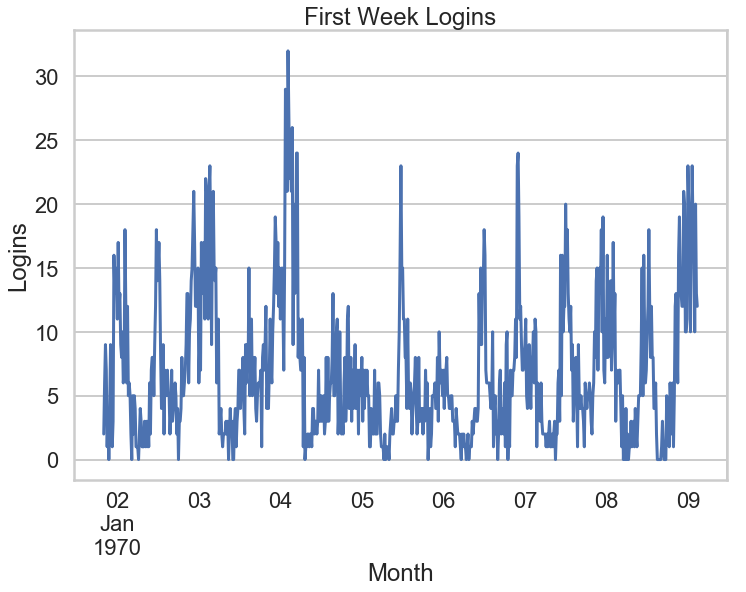

In [11]:
# Plotting First Week Logins
ax = date_range[0:700].plot()
ax.set_xlabel('Month')
ax.set_ylabel('Logins')
ax.set_title('First Week Logins')

** For the first week, January 4th (which was a Sunday) saw the biggest jump in logins for the week. Also, the amount of logins tends to peak about twice a day.**

Text(0.5,1,'First Two Weeks Logins')

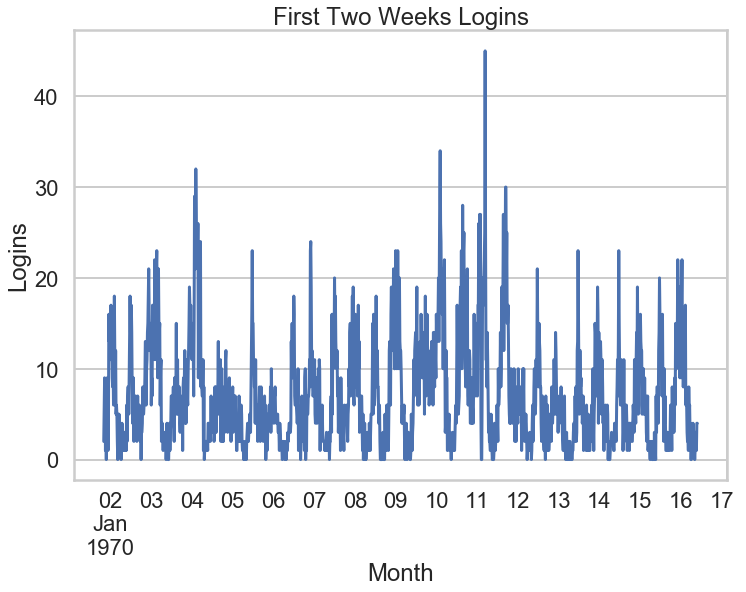

In [12]:
# Plotting First Two Weeks Logins
ax = date_range[0:1400].plot()
ax.set_xlabel('Month')
ax.set_ylabel('Logins')
ax.set_title('First Two Weeks Logins')

** Looking at the first two weeks, we can see that January 11th also has the biggest jump in logins for the second week and, like January 4th, is a Sunday. Plus, as seen earlier, there are about 2 peaks a day.**

## Conclusion
After filtering the logins into 15-minute increments, I found that the amount of logins tends to peak about twice a day with the highest weekly amounts appearing to be on Sundays. Also, as the year went along, there were more logins per day especially as you get into April.
<br>

When it came to the data, there did not seem to be any quality issues. There was no missing data and the only thing that needed fixing was sorting the values so they were in ascending order for login times. It would have been nice to know in the data which exact day of the week each date fell on but that is a minor issue.

## Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
<br>

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
<br>

    a. how you will implement the experiment
    <br>

    b. what statistical test(s) you will conduct to verify the significance of the
    observation
    <br>

    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

** The key measure of success in the experiment would be how much more money do drivers make when working both cities. While paying for the tolls may help some, the actual time as well as effort it takes to drive people to and from both cities may not actually be worth the costs for reimbursing the tolls.**

** For an experiment, I would choose a certain amount of drivers (at random) to try out driving to both cities. When they are doing this, the company would reimburse them for tolls so that way the drivers would not need to worry about it. After a certain time frame (maybe six months), we would see how much money they are making by going to both cities.**
<br>

** When it comes to a statistical test, I would recommend a t-test, which would calculate the difference in means between the drivers that stay in one city as well as the sample size that is trying both cities. With that test, we can get an idea of how much more or less money the new group is making especially because t-tests are good when sample sizes are different.**
<br>

** Based on the results of the t-test, I would tell the city operations team whatever was the difference in money made for the sample size as well as break down the experiment for them so they fully understand the positives and negatives of the test. Now no matter what we find out from the t-test, the team knows the caveats with the results as well as what else needs to be considered when they make their ultimate decision.**

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
<br>

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
<br>

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
<br>

   1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
    <br>
    
   2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
    <br>
    
   3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

In [13]:
# Uploading Ultimate Data Challenge json and inspecting the data
with open('/Users/dwreiter/Desktop/Work/Springboard/Data Stuff/ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)

df_ultimate = pd.DataFrame(data)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
# Looking for missing data
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# Seeing how many NaNs are in average rating by driver
df_ultimate['avg_rating_by_driver'].value_counts(dropna=False)

 5.0    28508
 4.8     4537
 4.7     3330
 4.9     3094
 4.5     2424
 4.6     2078
 4.0     1914
 4.3     1018
 4.4      860
 3.0      602
 4.2      342
NaN       201
 3.5      199
 3.7      195
 1.0      181
 2.0      126
 4.1      125
 3.8      111
 3.3       47
 3.9       41
 2.5       31
 3.6       19
 3.4        5
 1.5        4
 2.8        3
 2.7        2
 3.2        2
 2.3        1
Name: avg_rating_by_driver, dtype: int64

In [16]:
# Seeing how many NaNs are in average rating of driver
df_ultimate['avg_rating_of_driver'].value_counts(dropna=False)

 5.0    20771
NaN      8122
 4.0     4193
 4.5     2498
 4.8     2430
 4.7     1945
 4.9     1771
 4.3     1487
 4.6     1143
 3.0     1003
 4.4      829
 4.2      601
 3.5      488
 3.8      428
 4.1      398
 3.7      364
 1.0      256
 3.9      255
 2.0      209
 3.3      201
 3.6      172
 3.4      108
 2.5       94
 3.2       53
 2.7       47
 3.1       39
 2.8       28
 2.3       22
 2.9       13
 2.6       12
 2.1        6
 1.5        4
 2.4        3
 1.8        2
 1.7        2
 2.2        1
 1.9        1
 1.6        1
Name: avg_rating_of_driver, dtype: int64

In [17]:
# Seeing how many NaNs are in phone
df_ultimate['phone'].value_counts(dropna=False)

iPhone     34582
Android    15022
NaN          396
Name: phone, dtype: int64

** Because I do not want to assume what reviews people were given as well as the phones that were used, I have decided to just drop all of the rows with missing data. The dataset is large enough that it should not have much of an impact on my analysis moving forward.**

In [18]:
# Dropping all NaNs
df_ultimate = df_ultimate.dropna()
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null object
phone                     41445 non-null object
signup_date               41445 non-null object
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


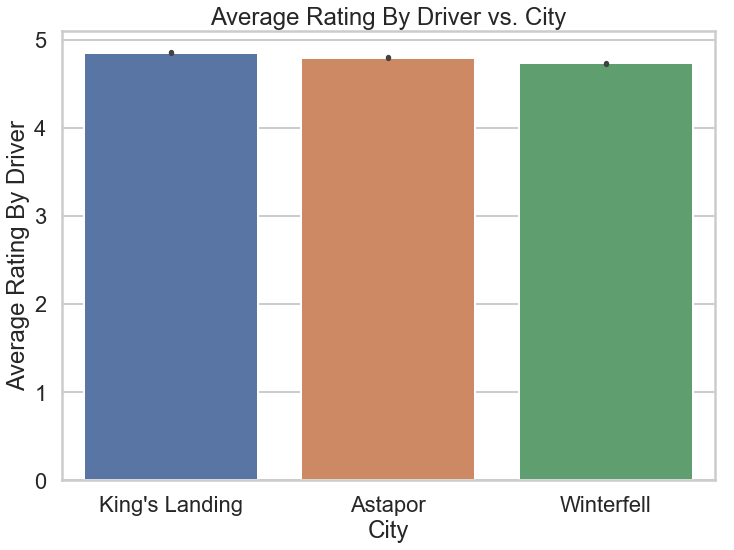

In [19]:
# Plotting Average Rating By Driver vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['avg_rating_by_driver'])
_ = plt.xlabel('City')
_ = plt.ylabel('Average Rating By Driver')
_ = plt.title('Average Rating By Driver vs. City')

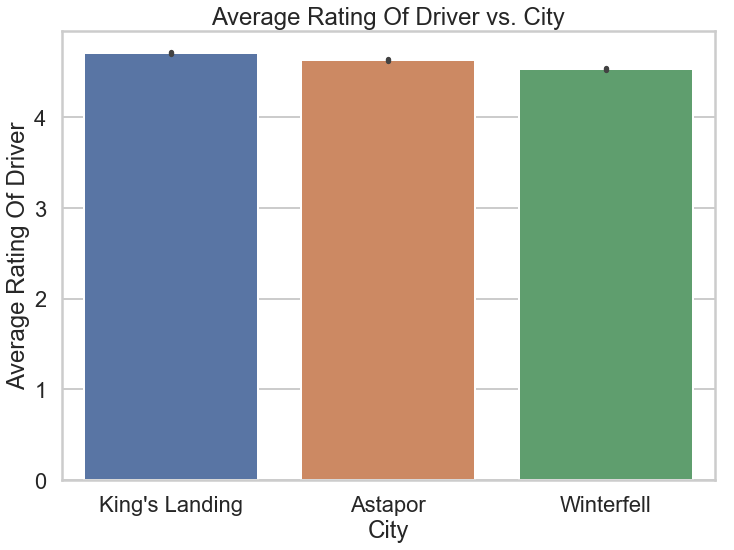

In [20]:
# Plotting Average Rating Of Driver vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['avg_rating_of_driver'])
_ = plt.xlabel('City')
_ = plt.ylabel('Average Rating Of Driver')
_ = plt.title('Average Rating Of Driver vs. City')

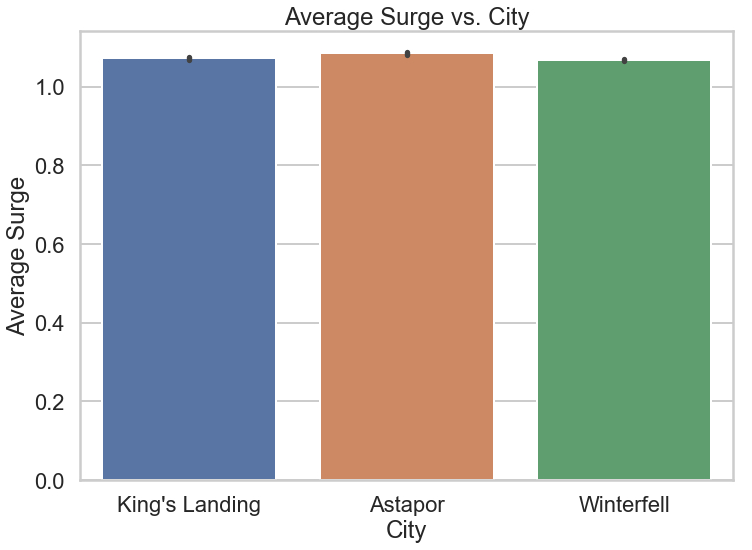

In [21]:
# Plotting Average Surge vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['avg_surge'])
_ = plt.xlabel('City')
_ = plt.ylabel('Average Surge')
_ = plt.title('Average Surge vs. City')

** When comparing the cities with Average Rating by Driver, Average Rating of Driver and Average Surge, there isn't much of a difference between the three.**

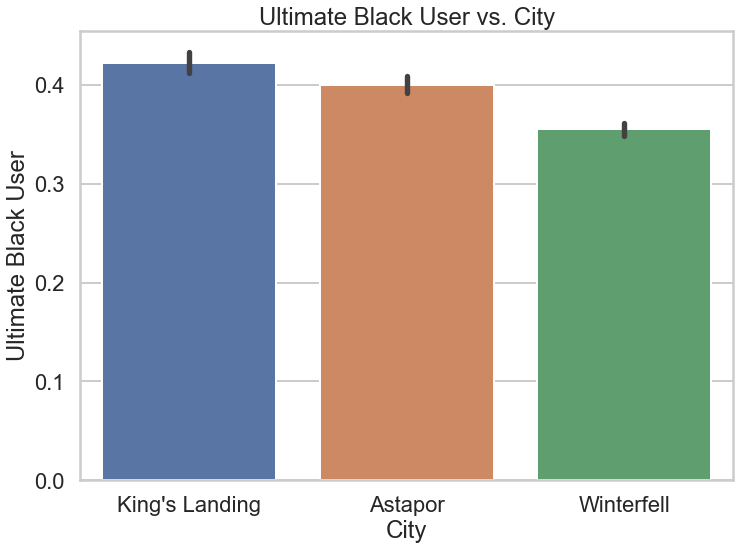

In [22]:
# Plotting Ultimate Black User vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['ultimate_black_user'])
_ = plt.xlabel('City')
_ = plt.ylabel('Ultimate Black User')
_ = plt.title('Ultimate Black User vs. City')

** When it comes to using Ultimate Black in their first 30 days, there were more users who did it in King's Landing followed closely by Astapor City while Winterfell had the least. However, none were above 50%.**

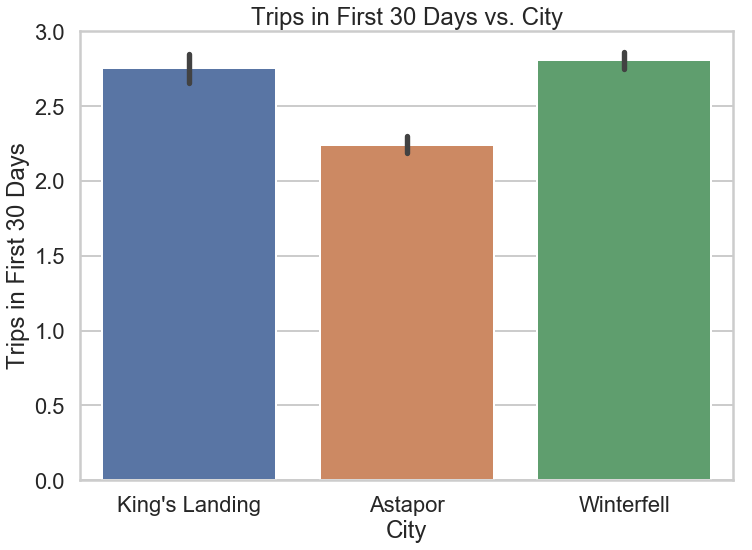

In [23]:
# Plotting Trips in First 30 Days vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['trips_in_first_30_days'])
_ = plt.xlabel('City')
_ = plt.ylabel('Trips in First 30 Days')
_ = plt.title('Trips in First 30 Days vs. City')

** For Trips in First 30 Days, Winterfell narrowly edges out King's Landing for the most while Astapor City is well behind. This makes me think that Astapor City may have the smallest population of the three areas.**

In [24]:
# Seeing when the earliest signup date and latest last trip date
df_ultimate[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,41445,41445
unique,182,31
top,2014-06-29,2014-01-18
freq,1924,2473


In [25]:
# Creating a column that sees if user was active during the last 30 days
df_ultimate['retained'] = np.nan
df_ultimate.loc[df_ultimate['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df_ultimate.loc[df_ultimate['last_trip_date'] < '2014-06-01', 'retained'] = 0
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [26]:
# Fraction of retained users
df_ultimate['retained'].sum()/len(df_ultimate)

0.41102666184099407

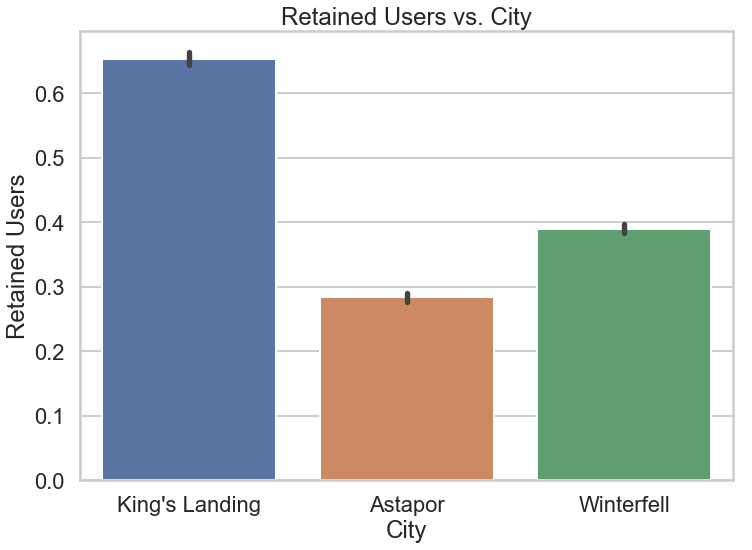

In [27]:
# Plotting Retained Users vs. City
_ = sns.barplot(df_ultimate['city'], df_ultimate['retained'])
_ = plt.xlabel('City')
_ = plt.ylabel('Retained Users')
_ = plt.title('Retained Users vs. City')

** Based on my calculations, it looks like about 41% of users were retained. When it came to each city, King's Landing had by far the most retained users as there is a steep drop before Winterfell. Astapor City has the fewest amount, which strongly supports my belief that it is the least populated city while King's Landing is likely the most populated.**

** For predictive models, I will use both Logistic Regression and Random Forest. The reason is that the results are binary (a user is retained or not) which is good for Logistic Regression plus Random Forest will help extract important features.**

In [28]:
# Removing unnecessary columns for Machine Learning
df_ultimate.drop('last_trip_date', axis=1, inplace=True)
df_ultimate.drop('signup_date', axis=1, inplace=True)


# Setting Retained Users to y
y = df_ultimate['retained'].values

# Dropping Retained Users from DataFrame so it will not be a part of X variable
df_ultimate = df_ultimate.drop('retained', axis=1)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4


In [29]:
# Converting Categorical variables into Dummy Variables
df_ultimate = pd.get_dummies(df_ultimate, columns = ['city', 'phone', 'ultimate_black_user'])
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,1,0


In [30]:
# Setting X to the rest of the columns in df_ultimate
X = df_ultimate

# Splitting the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [31]:
# Setting up parameter C
c_space = np.logspace(-5, 8, 5)
param_grid = {'C': c_space}

# Setting up Logistic Regression Model
LR = LogisticRegression()

# Using GridSearchCV to help avoid overfitting
CV = GridSearchCV(LR, param_grid, cv=5)

In [32]:
# Fitting the training data
CV.fit(X_train, y_train)

# Setting up prediction based on testing data for X
y_pred = CV.predict(X_test)

# Calculating the accuracy and area under the ROC curve
score = metrics.accuracy_score(y_test, y_pred)
AUC = roc_auc_score(y_test, y_pred)

print('Accuracy Score: ' + str(score))
print('Area Under the ROC Curve: ' + str(AUC))

Accuracy Score: 0.711786705272
Area Under the ROC Curve: 0.68606717596


** The accuracy is around 71% while the AUC score is around 69%. This is not bad but we should also look at the Confusion Matrix and Classification Report.**

In [33]:
# Creating the Confusion Matrix and Classification Report
CM = metrics.confusion_matrix(y_test, y_pred)
CR = metrics.classification_report(y_test, y_pred)

print(CM)
print(CR)

[[4055  827]
 [1562 1845]]
             precision    recall  f1-score   support

        0.0       0.72      0.83      0.77      4882
        1.0       0.69      0.54      0.61      3407

avg / total       0.71      0.71      0.70      8289



** The precision and recall were each at 71%, which is essentially the same as the accuracy score. Now let's try a Random Forest model.**

In [34]:
# Setting up a Random Forest Classifier followed by fitting and predicting on the data
RF = RandomForestClassifier(n_estimators=1000, random_state=42)

RF.fit(X_train, y_train)

RF_pred = RF.predict(X_test)

RF_score = metrics.accuracy_score(y_test, RF_pred)
RF_AUC = roc_auc_score(y_test, RF_pred)

print('Accuracy Score: ' + str(RF_score))
print('Area Under the ROC Curve: ' + str(RF_AUC))

Accuracy Score: 0.751598504042
Area Under the ROC Curve: 0.742256315678


** With this model, the accuracy improved to about 75% while the AUC score increased to around 74%.**

In [35]:
# Printing out the Confusion Matrix and Classification Report for the Random Forest Classifier
RF_CM = metrics.confusion_matrix(y_test, RF_pred)
RF_CR = metrics.classification_report(y_test, RF_pred)

print(RF_CM)
print(RF_CR)

[[3880 1002]
 [1057 2350]]
             precision    recall  f1-score   support

        0.0       0.79      0.79      0.79      4882
        1.0       0.70      0.69      0.70      3407

avg / total       0.75      0.75      0.75      8289



** Once again, the precision and recall are the same as the accuracy score which is 75%.**
<br>

** Now that we have a better model, we will find out which features are considered the most important.**

In [36]:
# Calculating Feature Importance from the Random Forest Classifier
RF_Features = pd.Series(RF.feature_importances_, index=X.columns).sort_values(ascending=False)
RF_Features

avg_dist                     0.276657
weekday_pct                  0.142714
avg_rating_by_driver         0.117303
surge_pct                    0.082886
trips_in_first_30_days       0.081396
avg_rating_of_driver         0.080944
avg_surge                    0.070023
city_King's Landing          0.045140
phone_iPhone                 0.019774
phone_Android                0.019526
ultimate_black_user_False    0.018444
ultimate_black_user_True     0.017826
city_Astapor                 0.016360
city_Winterfell              0.011007
dtype: float64

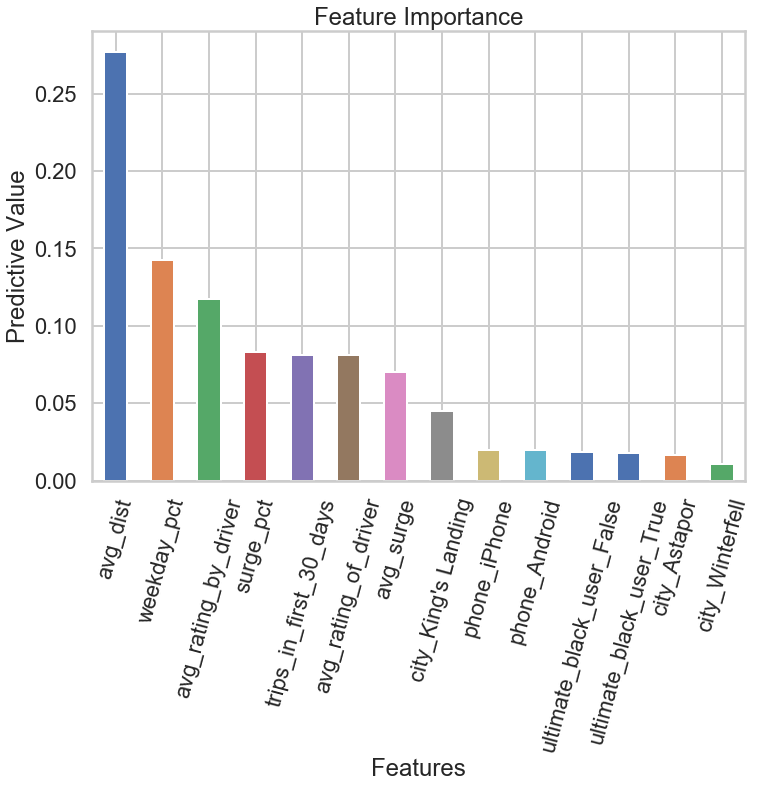

In [37]:
# Plotting Feature Importance
_ = RF_Features.plot(kind='bar')
_ = plt.xticks(rotation=75)
_ = plt.xlabel('Features')
_ = plt.ylabel('Predictive Value')
_ = plt.title('Feature Importance')

** It looks like Average Distance was the most important feature in the data, followed by Weekday Percentage and Average Rating By Driver. The categorical data like City, Phone and Ultimate Black user were the least important.**

## Conclusion
Based on the Random Forest model, it appears that the average distance in miles per trip taken in the first 30 days after signup is by far the most important factor for rider retention. This means that how long trips are for a user's first 30 days is the key to keeping them long-term. Also, the amount of weekday trips and the rider’s average rating over all of their trips are important to keep in mind as well. Factors like the city the user signed up in, the user's phone and if they took an Ultimate Black in their first 30 days are not critical and should not be focused on moving forward. Instead, the trips themselves are what will keep users coming back.